# Pytorch Image Reconstruction (Auto Encoder Model for VGG)

In [1]:


# # install pillow
# !pip install Pillow -U
# !pip install natsort -U
# !pip install ipywidgets -U

     |████████████████████████████████| 3.1 MB 5.2 MB/s            
  Attempting uninstall: Pillow
    Found existing installation: Pillow 8.3.2
    Uninstalling Pillow-8.3.2:
      Successfully uninstalled Pillow-8.3.2


In [6]:
# # download and unzip dataset o train
# !mkdir dataset/train
# %cd dataset/train
# !wget http://images.cocodataset.org/zips/train2014.zip
# !unzip -qq train2014.zip 
# %cd ../..

/home/jupyter/pytorch-universal-style-transfer/notebooks/dataset/train
--2022-01-02 03:30:48--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.133.97
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.133.97|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: ‘train2014.zip’

train2014.zip       100%[===================>]  12.58G  49.6MB/s    in 4m 2s   

2022-01-02 03:34:51 (53.2 MB/s) - ‘train2014.zip’ saved [13510573713/13510573713]

/home/jupyter/pytorch-universal-style-transfer/notebooks


In [7]:
# !mkdir dataset/test
# %cd dataset/test
# !wget http://images.cocodataset.org/zips/test2014.zip
# !unzip -qq test2014.zip 
# %cd ../..

/home/jupyter/pytorch-universal-style-transfer/notebooks/dataset/test
--2022-01-02 03:38:47--  http://images.cocodataset.org/zips/test2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.32.28
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.32.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6660437059 (6.2G) [application/zip]
Saving to: ‘test2014.zip’

test2014.zip        100%[===================>]   6.20G  37.3MB/s    in 2m 20s  

2022-01-02 03:41:07 (45.4 MB/s) - ‘test2014.zip’ saved [6660437059/6660437059]

/home/jupyter/pytorch-universal-style-transfer/notebooks


In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from PIL import Image
from torchvision.utils import save_image
from torch.utils.data import Dataset
import natsort
import os
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Dataset for Task

Our task is to create an autoencoder based on VGG19 that reduces images to a latent space and then upsamples them back to original size. This will essentially train a network to take information from a dense, compressed state in the smaller hidden layers to create more complete images.

In [3]:
#Image Helper Functions


imsize = 512 if torch.cuda.is_available() else 256

preprocess = transforms.Compose([
          transforms.Resize(imsize),
          transforms.CenterCrop(imsize),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])


unloader = transforms.ToPILImage()  # reconvert into PIL image

def image_to_tensor(filename):
    input_image = Image.open(filename)
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
    return input_batch.to(device)

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it

    inv_normalize = transforms.Normalize(
      mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
      std=[1/0.229, 1/0.224, 1/0.225]
      ) 
    image = inv_normalize(image) # inverse the normalization we did on the image

    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated
    

def imsave(tensor, filename):
    image = tensor.cpu().clone()
    inv_normalize = transforms.Normalize(
      mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
      std=[1/0.229, 1/0.224, 1/0.225]
    ) 
    image = inv_normalize(image)

    save_image(image, filename)

In [4]:
# training dataset


# Custom UnsupervisedImageFolder class

class UnsupervisedImageFolder(Dataset):
    def __init__(self, root, transform):
        self.root = root
        self.transform = transform
        all_imgs = os.listdir(root)
        self.total_imgs = natsort.natsorted(all_imgs)
    
    def __len__(self):
        return len(self.total_imgs)
    
    def __getitem__(self, idx):
        img_loc = os.path.join(self.root, self.total_imgs[idx])
        img = Image.open(img_loc).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        return img
    
    def __repr__(self):
        fmt_str = 'Unsupervised Image Dataset' + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str

TRAIN_PATH='dataset/train/train2014/'
TEST_PATH='dataset/test/test2014/'
BATCH_SIZE=8

train_dataset = UnsupervisedImageFolder(TRAIN_PATH, transform=preprocess)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = UnsupervisedImageFolder(TEST_PATH, transform=preprocess)
test_load = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


Unsupervised Image Dataset
    Number of datapoints: 82783
    Root Location: dataset/train/train2014/
    Transforms (if any): Compose(
                             Resize(size=512, interpolation=bilinear, max_size=None, antialias=None)
                             CenterCrop(size=(512, 512))
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )

torch.Size([3, 512, 512])


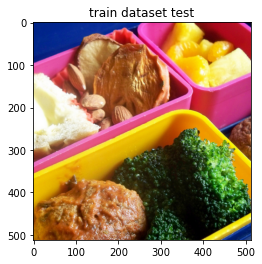

In [7]:
# Dataset tests
print(train_dataset)
print(train_dataset[0].shape)
imshow(train_dataset[0], "train dataset test")

torch.Size([16, 3, 512, 512])
torch.Size([3, 512, 512])


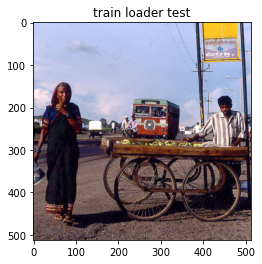

In [36]:
img_batch = next(iter(train_loader))
print(img_batch.shape)
img = img_batch[0]
print(img.shape)
imshow(img, "train loader test")
del img
del img_batch

## Model Architecture

In [37]:
# model = torchvision.models.vgg19(pretrained=True)

# model_path = 'models/vgg19-dcbb9e9d.pth'
# # model.load_state_dict(torch.load(model_path), strict=False)
# model.eval()
# model.to(device)
# del model

Here, I'm choosing to ignore instance normalization, which is seen to greatly increase model performce, will come back later

Using upsample code for maxpool layers and decov layers
https://github.com/mtliba/360-images-VGG-based-Autoencoder-Pytorch/blob/master/model.py 

In [5]:
class Interpolate(nn.Module):
    def __init__(self, scale_factor):
        super(Interpolate, self).__init__()
        self.interp = nn.functional.interpolate
        self.scale_factor = scale_factor
        
    def forward(self, x):
        x = self.interp(x, scale_factor=self.scale_factor)
        return x

class VGGAutoEncoder(torch.nn.Module):
    def __init__(self, rep_layer='relu_5_1', vgg_version='vgg19', vgg_path=None, wct_layer=None):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.rep_layer = rep_layer
        self.encoder = nn.Sequential()

        vgg = torchvision.models.vgg19(pretrained=True if not vgg_path else False)
        if vgg_path:
            vgg.load_state_dict(torch.load(vgg_path), strict=False)

        i = 1
        j = 1
        for layer in vgg.features.children():
            if isinstance(layer, nn.Conv2d):
                name = f"conv{i}_{j}"
            elif isinstance(layer, nn.MaxPool2d):
                name = f"maxpool_{i}"
                i += 1
                j = 1

            elif isinstance(layer, nn.ReLU):
                name = f"relu_{i}_{j}"
                j += 1
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            self.encoder.add_module(name, layer)
            if name == rep_layer: break
                
        self.wct = wct_layer

        self.decoder = nn.Sequential()
        
        for name, layer in list(self.encoder.named_children())[::-1]:
            new_name, new_layer = None, None
            if isinstance(layer, nn.Conv2d):
                new_name = "de" + name
                new_layer = nn.ConvTranspose2d(layer.out_channels, layer.in_channels, kernel_size=layer.kernel_size,stride=layer.stride, padding=layer.padding)
            elif isinstance(layer, nn.MaxPool2d):
                new_name = "upsample_" + name[-1]
                new_layer = Interpolate(scale_factor=2)
            elif isinstance(layer, nn.ReLU):
                new_name = "mir_"+ name
                new_layer = nn.ReLU(inplace=True)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
            self.decoder.add_module(new_name, new_layer)
        del vgg

            
    def forward(self, x, style=None):
        enc_x = self.encoder(x)
        if self.wct and style:
            enc_x = self.wct(enc_x, style)
        dec_x = self.decoder(enc_x)
        
        if self.training:
            dec_enc = self.encoder(dec_x)
            return dec_x, enc_x, dec_enc
        return dec_x
            

In [6]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([3, 512, 512]) torch.Size([1, 256, 128, 128]) torch.Size([1, 3, 512, 512])


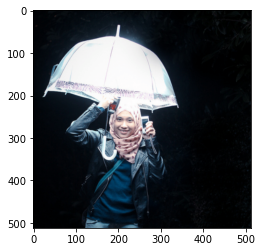

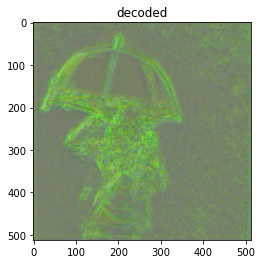

torch.Size([8, 3, 512, 512]) torch.Size([8, 256, 128, 128])
82783


In [10]:
torch.cuda.empty_cache()

img_batch = next(iter(train_loader))
img_batch = img_batch.to(device)
img = img_batch[0]


ae = VGGAutoEncoder(rep_layer="relu_3_1").to(device)
ae.train()

dec, enc, _ = ae(img.unsqueeze(0))

print(img.shape, enc.shape, dec.shape)
imshow(img)
imshow(dec, "decoded")

dec_batch, enc_batch, _ = ae(img_batch)
print(dec_batch.shape, enc_batch.shape)

print(len(train_dataset))

## Training Loop
As described in [Li et al.](https://arxiv.org/abs/1705.08086), we need to train 5 decoders at different levels of the ReLU output of VGG. we will be using the same Data Loader to train all 5 models concurrently. 

In [11]:
# Configs
LEARNING_RATE = 0.01
EPOCHS = 100
LAMBDA = 1
SAVE_MODEL_EVERY = 500
SAVE_MODEL_PATH="model/"

In [12]:
from torch.nn.functional import mse_loss
from torch.optim import Adam
import time
from pathlib import Path

def train(step, batch, model, optim):
    
    # Set training mode
    model.train()
    
    # Zero Gradient
    optim.zero_grad()  

    
    # Put batch on GPU
    batch = batch.to(device)
    
    #Get model output
    decoder_output, encoded_img, encoded_decoder_img = model(batch)
    
    # Calcuate and Track loss
    
    # Reconstruction loss gets per-pixel loss and averages for each image in the batch
    reconstruction_loss = mse_loss(decoder_output, batch, reduction="sum") / batch.size(0)
    
    # Feature loss is the per-element loss of the encoded layer for each image in the batch
    feature_loss = mse_loss(encoded_decoder_img, encoded_img, reduction="sum") / batch.size(0)
    
    # Total loss is a weighted sum of the two losses above, parameterized by a weight lambda
    total_loss = reconstruction_loss + LAMBDA * feature_loss
    
    # back prop
    total_loss.backward()
    optim.step()
    
    if (step == 0) or ((step+1) % SAVE_MODEL_EVERY == 0) or (step==EPOCHS*len(train_loader) - 1):
        # Print Losses
        print("========Iteration {}/{}========".format(step+1, EPOCHS*len(train_loader)))
        print("\tReconstruction Loss:\t{:.2f}".format(reconstruction_loss))
        print("\tFeature Loss:\t{:.2f}".format(feature_loss))
        print("\tTotal Loss:\t{:.2f}".format(total_loss))
        
        # Save Model
        model_name = model.rep_layer + "_autoencoder"
        checkpoint_path = os.path.join(SAVE_MODEL_PATH, model_name, "checkpoints")
        image_sample_path = os.path.join(SAVE_MODEL_PATH, model_name, "samples")
        Path(checkpoint_path).mkdir(parents=True, exist_ok=True) 
        Path(image_sample_path).mkdir(parents=True, exist_ok=True)
        
        checkpoint_name = "checkpoint_" + str(step+1) + ".pth"
        if step==EPOCHS*len(train_loader) - 1:
            checpoint_name = "final.pth"
        torch.save(model.state_dict(), os.path.join(checkpoint_path, checkpoint_name))
        print("Saved VGGAutoEncoder checkpoint file at {}".format(checkpoint_path))
        
        # Save sample generated image
        sample_tensor = decoder_output[0]
        imshow(sample_tensor, f"Step: {step+1}, loss={total_loss}")
        imsave(sample_tensor, os.path.join(image_sample_path, f"sample_{step}.jpg")) 
        print("Saved sample tranformed image at {}".format(image_sample_path))
    return total_loss.item()
    
    
    

In [13]:
# Model Initialization


# models = [VGGAutoEncoder(rep_layer=layer,vgg_path=model_path) for layer in enc_layers]

# for model in models:
#     # turn off grad for encoders
#     for param in model.encoder.parameters():
#         param.requires_grad = False
    
#     # ... but explicitly track gradients in decoder
#     for param in model.decoder.parameters():
#         param.requires_grad = True

# # Optimizers for each model
# optimizers = [Adam(model.decoder.parameters(), lr=LEARNING_RATE) for model in models]


========Iteration 1/1034800========
	Reconstruction Loss:	4390082.00
	Feature Loss:	21156000.00
	Total Loss:	25546082.00
Saved VGGAutoEncoder checkpoint file at model/relu_1_1_autoencoder/checkpoints


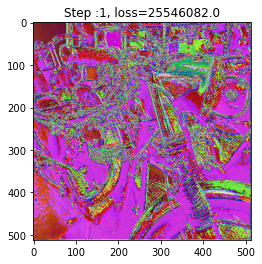

Saved sample tranformed image at model/relu_1_1_autoencoder/samples
========Iteration 500/1034800========
	Reconstruction Loss:	27923.87
	Feature Loss:	297030.50
	Total Loss:	324954.38
Saved VGGAutoEncoder checkpoint file at model/relu_1_1_autoencoder/checkpoints


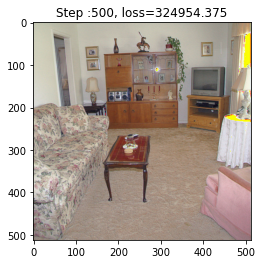

Saved sample tranformed image at model/relu_1_1_autoencoder/samples
========Iteration 1000/1034800========
	Reconstruction Loss:	15491.93
	Feature Loss:	139589.47
	Total Loss:	155081.41
Saved VGGAutoEncoder checkpoint file at model/relu_1_1_autoencoder/checkpoints


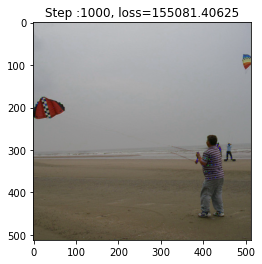

Saved sample tranformed image at model/relu_1_1_autoencoder/samples


In [ ]:
enc_layers = [f"relu_{i+1}_1" for i in range(5)]
for enc_name in enc_layers:
    model = VGGAutoEncoder(rep_layer=enc_name).to(device)
    
    # freeze encoder, update decoder
    for param in model.encoder.parameters():
        param.requires_grad = False
    for param in model.decoder.parameters():
        param.requires_grad = True
    optimizer = Adam(model.decoder.parameters(), lr=LEARNING_RATE)
    
    start_time = time.time()

    for epoch in range(EPOCHS):
        t_loss = 0
        for batch_id, batch in enumerate(train_loader):
            
            t_loss += train(len(train_loader) * epoch + batch_id, batch, model, optimizer)
        print(f"Loss for Epoch: {t_loss/ (epoch+1)}, took {time.time()-start_time} ms.\n\n")
               